# Subsonic Inviscid Flow Around a Blunted Cone (2D Axisymmetric)

Minimal Euler-equation test on the blunted-cone mesh.  No viscosity, no chemistry,
single species (N2).  The goal is to check that the physically correct flow pattern
develops:

- **Stagnation region** (high pressure, low speed) at the blunt nose
- **Acceleration / pressure drop** around the shoulder
- **Streamlines deflected** symmetrically around the body axis

**Freestream:** Mach 0.5, T = 300 K, p = 101325 Pa (sea level N2)

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # or "cpu" if you want to run on CPU

import sys
from pathlib import Path

repo_root = Path("/home/hhoechter/tum/jaxfluids_internship")
sys.path.insert(0, str(repo_root / "src"))

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

from compressible_core import chemistry_utils, energy_models
from compressible_2d import (
    mesh_gmsh,
    equation_manager,
    equation_manager_types,
    equation_manager_utils,
    numerics_types,
)

print(jax.default_backend())

cpu


In [2]:
# ---- freestream conditions ----
T_inf   = 300.0      # translational temperature [K]
p_inf   = 101325.0   # pressure [Pa]

R_N2    = 8314.46 / 28.014    # specific gas constant N2 [J/(kg K)]
gamma   = 1.4
a_inf   = (gamma * R_N2 * T_inf) ** 0.5   # speed of sound [m/s]
mach    = 0.5
V_inf   = mach * a_inf                    # freestream axial speed [m/s]
rho_inf = p_inf / (R_N2 * T_inf)          # density [kg/m^3]

print(f"Speed of sound:   {a_inf:.2f} m/s")
print(f"Freestream speed: {V_inf:.2f} m/s  (Mach {mach})")
print(f"Density:          {rho_inf:.4f} kg/m^3")

# Boundary tags -- match the defaults in run_blunt_cone.py
TAG_INFLOW       = 1
TAG_OUTFLOW      = 2
TAG_WALL         = 3
TAG_AXISYMMETRIC = 4

Speed of sound:   353.06 m/s
Freestream speed: 176.53 m/s  (Mach 0.5)
Density:          1.1380 kg/m^3


In [3]:
data_dir = repo_root / "data"

# bluntedCone.msh is a 3D thin-wedge mesh; extract one wedge plane as the 2D domain.
# Physical tags in the file: 1=inlet, 2=outlet, 3=cone(wall), 4=wedge1, 7=axis
# Remap axis tag 7 -> 4 to match TAG_AXISYMMETRIC below.
mesh = mesh_gmsh.read_gmsh_v2_wedge_plane(
    str(data_dir / "bluntedCone.msh"),
    wedge_plane_tag=4,
    remap_tags={7: TAG_AXISYMMETRIC},
    axis_tag=TAG_AXISYMMETRIC,   # geometric fallback for axis edges not in the gmsh file
)
n_cells = mesh.cell_areas.shape[0]
print(f"Mesh:   {n_cells} cells,  {mesh.nodes.shape[0]} nodes")
print(f"r in  [{mesh.cell_centroids[:, 0].min():.4f},  {mesh.cell_centroids[:, 0].max():.4f}] m")
print(f"z in  [{mesh.cell_centroids[:, 1].min():.4f},  {mesh.cell_centroids[:, 1].max():.4f}] m")
print(f"Boundary tags present: {np.unique(mesh.boundary_tags[mesh.boundary_tags >= 0])}")

energy_cfg = energy_models.EnergyModelConfig(
    model="bird",
    include_electronic=False,
    data_path=str(data_dir / "air_5_bird_energy.json"),
)
species = chemistry_utils.load_species_table(
    species_names=("N2",),
    general_data_path=str(data_dir / "species.json"),
    energy_model_config=energy_cfg,
)
print(f"Species loaded: {species.names}")

Mesh:   120000 cells,  241401 nodes
r in  [0.0045,  0.0519] m
z in  [0.0000,  0.0346] m
Boundary tags present: [1 2 3 4]
Species loaded: ('N2',)


In [9]:
boundary_config = equation_manager_types.BoundaryConditionConfig2D(
    tag_to_bc={
        TAG_INFLOW: {
            "type": "inflow",
            "rho": rho_inf,
            "u":   0.0,      # radial component -- zero for axisymmetric freestream
            "v":   V_inf,    # axial component
            "T":   T_inf,
            "Tv":  T_inf,
            "Y":   [1.0],    # pure N2
        },
        TAG_OUTFLOW:       {"type": "outflow"},
        TAG_WALL:          {"type": "wall", "Tw": T_inf},
        TAG_AXISYMMETRIC:  {"type": "axisymmetric"},
    }
)

numerics_config = numerics_types.NumericsConfig2D(
    dt=1e-10,
    cfl=0.4,
    dt_mode="fixed",
    integrator_scheme="rk2",
    spatial_scheme="muscl",
    flux_scheme="hllc",
    axisymmetric=True,
    clipping=numerics_types.ClippingConfig2D(),
)

eq_manager = equation_manager_utils.build_equation_manager(
    mesh,
    species=species,
    collision_integrals=None,
    reactions=None,        # frozen chemistry
    numerics_config=numerics_config,
    boundary_config=boundary_config,
    transport_model=None,  # inviscid: mu = kappa = 0  (pure Euler equations)
    casseau_transport=None,
)
print("Equation manager ready  (inviscid, non-reacting)")

t_final       = 1e-5
save_interval = 10


Equation manager ready  (inviscid, non-reacting)


In [5]:
# Uniform freestream initial condition
U_init = equation_manager_utils.compute_U_from_primitives(
    Y_s=jnp.ones((n_cells, 1)),
    rho=jnp.full((n_cells,), rho_inf),
    u=jnp.zeros((n_cells,)),
    v=jnp.full((n_cells,), V_inf),
    T_tr=jnp.full((n_cells,), T_inf),
    T_V=jnp.full((n_cells,), T_inf),
    equation_manager=eq_manager,
)
print(f"U_init shape: {U_init.shape}   (n_cells x n_variables)")

# ------------------------------------------------------------------
# Estimate CFL timestep and memory before committing to the run.
# # Snapshots are stored on CPU, so the limit is host RAM, not GPU.
# # ------------------------------------------------------------------
# dt_est        = equation_manager.compute_cfl_dt(U_init, mesh, eq_manager)
# t_final       = 1e-5    # [s]  adjust to balance runtime vs. convergence
# save_interval = 50      # save a snapshot every N time steps
# n_steps_est   = int(t_final / dt_est)
# n_snaps_est   = n_steps_est // save_interval + 1
# mem_mb        = n_snaps_est * n_cells * U_init.shape[1] * 4 / 1e6

# print(f"\nCFL dt estimate  : {dt_est:.3e} s")
# print(f"Steps estimate   : {n_steps_est:,}")
# print(f"Snapshots        : {n_snaps_est}")
# print(f"Host RAM needed  : {mem_mb:.1f} MB  (float32)")
# print("\nAdjust t_final / save_interval above if needed, then run the next cell.")


U_init shape: (120000, 5)   (n_cells x n_variables)


In [6]:
dt_cfl = equation_manager.compute_cfl_dt(U_init, mesh, eq_manager)
dt_fixed = eq_manager.numerics_config.dt
cfl_actual = dt_fixed / (dt_cfl / eq_manager.numerics_config.cfl)

n_steps_est = int(t_final / dt_cfl)
n_snaps_est = n_steps_est // save_interval + 1
mem_mb = n_snaps_est * n_cells * U_init.shape[1] * 4 / 1e6

print(f"CFL-stable dt     : {dt_cfl:.3e} s  (with CFL={eq_manager.numerics_config.cfl})")
print(f"Current fixed dt  : {dt_fixed:.3e} s  (effective CFL = {cfl_actual:.3f})")
print(f"Steps estimate    : {n_steps_est:,}  (if using CFL dt)")
print(f"Snapshots         : {n_snaps_est}")
print(f"Host RAM needed   : {mem_mb:.1f} MB  (float32)")

CFL-stable dt     : 7.456e-10 s  (with CFL=0.4)
Current fixed dt  : 1.000e-06 s  (effective CFL = 536.476)
Steps estimate    : 13,411  (if using CFL dt)
Snapshots         : 1342
Host RAM needed   : 3220.8 MB  (float32)


In [7]:
dt_cfl

7.456059658572656e-10

In [ ]:
print(f"Running to t = {t_final:.2e} s  (save every {save_interval} steps)")

U_hist, t_hist = equation_manager.run_scan(
    U_init, mesh, eq_manager,
    t_final=t_final,
    save_interval=save_interval,
)

print(f"\nDone.  Snapshots: {U_hist.shape[0]},   t[-1] = {float(t_hist[-1]):.3e} s")


Running to t = 1.00e-05 s  (save every 10 steps)


In [ ]:
# Extract primitive variables from the last snapshot
U_last = U_hist[-1]

_, rho_f, u_f, v_f, _T_f, _Tv_f, p_f = equation_manager_utils.extract_primitives_from_U(
    U_last, eq_manager
)

cx   = np.array(mesh.cell_centroids[:, 0])   # r coordinate [m]
cy   = np.array(mesh.cell_centroids[:, 1])   # z coordinate [m]
u_np = np.array(u_f)                          # radial velocity  [m/s]
v_np = np.array(v_f)                          # axial velocity   [m/s]
p_np = np.array(p_f)                          # pressure         [Pa]
vmag = np.hypot(u_np, v_np)                   # velocity magnitude [m/s]

t_last = float(t_hist[-1])
print(f"t = {t_last:.3e} s")
print(f"p    in [{p_np.min():.0f},  {p_np.max():.0f}]  Pa")
print(f"|v|  in [{vmag.min():.1f},  {vmag.max():.1f}]  m/s")

t = 1.000e-07 s
p    in [nan,  nan]  Pa
|v|  in [nan,  nan]  m/s


In [ ]:
jnp.isnan(U_hist[-1])

Array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]], dtype=bool)

In [ ]:
# Build a matplotlib Triangulation: quads are split into two triangles
nodes_r  = np.array(mesh.nodes[:, 0])
nodes_z  = np.array(mesh.nodes[:, 1])
cell_len = np.array([len(c) for c in mesh.cells])

tri_i, tri_j, tri_k = [], [], []
for cell_nodes in mesh.cells:
    if len(cell_nodes) == 3:
        tri_i.append(cell_nodes[0])
        tri_j.append(cell_nodes[1])
        tri_k.append(cell_nodes[2])
    else:  # quad
        tri_i.append(cell_nodes[0]); tri_j.append(cell_nodes[1]); tri_k.append(cell_nodes[2])
        tri_i.append(cell_nodes[0]); tri_j.append(cell_nodes[2]); tri_k.append(cell_nodes[3])

triang = mtri.Triangulation(
    nodes_r, nodes_z,
    np.column_stack([tri_i, tri_j, tri_k]),
)

# For each triangle, we need the value of its parent cell.
# Quads produce 2 triangles with the same cell value.
repeat_counts = np.where(cell_len == 4, 2, 1)

def cell_to_tri(vals: np.ndarray) -> np.ndarray:
    """Expand cell-centred scalar to per-triangle values."""
    return np.repeat(vals, repeat_counts)

print(f"Triangulation: {len(tri_i)} triangles from {n_cells} cells")

Triangulation: 482798 triangles from 241400 cells


Quiver sample: 356 arrows


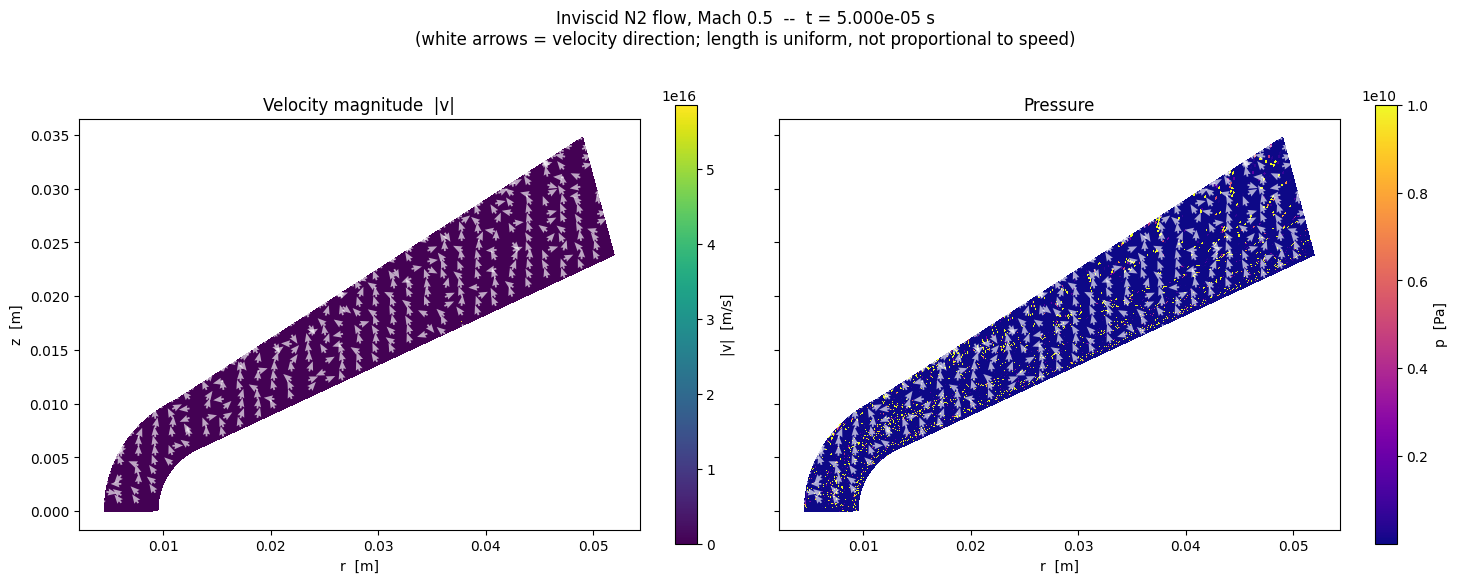

In [ ]:
# ---- helpers for the quiver overlay ----

def spatial_thin(cx: np.ndarray, cy: np.ndarray, n_r: int = 30, n_z: int = 40) -> np.ndarray:
    """Return one representative cell index per (r_bin, z_bin) for a uniform vector sample."""
    r_bins  = np.linspace(cx.min(), cx.max(), n_r + 1)
    z_bins  = np.linspace(cy.min(), cy.max(), n_z + 1)
    r_idx   = np.clip(np.digitize(cx, r_bins) - 1, 0, n_r - 1)
    z_idx   = np.clip(np.digitize(cy, z_bins) - 1, 0, n_z - 1)
    bin_key = r_idx * n_z + z_idx
    order   = np.argsort(bin_key, kind="stable")
    _, first_in_bin = np.unique(bin_key[order], return_index=True)
    return order[first_in_bin]


q_idx = spatial_thin(cx, cy, n_r=30, n_z=40)   # ~1200 arrows max
print(f"Quiver sample: {len(q_idx)} arrows")

# Normalise to unit vectors -- direction only; magnitude is encoded by the colormap
u_dir = u_np / (vmag + 1e-15)
v_dir = v_np / (vmag + 1e-15)

# Target arrow length in data coordinates: ~1/35 of the domain height.
# Increase arrow_len to make arrows longer; decrease to shorten them.
domain_h  = cy.max() - cy.min()
arrow_len = domain_h / 35.0

quiver_kw = dict(
    scale=1.0 / arrow_len,
    scale_units="xy",
    color="white",
    alpha=0.65,
    headwidth=4,
    headlength=5,
    headaxislength=4.5,
)

# ---- figure ----
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# --- Panel A: velocity magnitude ---
ax = axes[0]
tc = ax.tripcolor(triang, facecolors=cell_to_tri(vmag), cmap="viridis", shading="flat")
fig.colorbar(tc, ax=ax, label="|v|  [m/s]", shrink=0.85)
ax.quiver(cx[q_idx], cy[q_idx], u_dir[q_idx], v_dir[q_idx], **quiver_kw)
ax.set_xlabel("r  [m]")
ax.set_ylabel("z  [m]")
ax.set_aspect("equal")
ax.set_title("Velocity magnitude  |v|")

# --- Panel B: pressure ---
ax = axes[1]
tc = ax.tripcolor(triang, facecolors=cell_to_tri(p_np), cmap="plasma", shading="flat")
fig.colorbar(tc, ax=ax, label="p  [Pa]", shrink=0.85)
ax.quiver(cx[q_idx], cy[q_idx], u_dir[q_idx], v_dir[q_idx], **quiver_kw)
ax.set_xlabel("r  [m]")
ax.set_aspect("equal")
ax.set_title("Pressure")

fig.suptitle(
    f"Inviscid N2 flow, Mach {mach}  --  t = {t_last:.3e} s\n"
    "(white arrows = velocity direction; length is uniform, not proportional to speed)",
    fontsize=12,
)
plt.tight_layout()
plt.savefig("subsonic_inviscid_flow.png", dpi=150, bbox_inches="tight")
plt.show()